# Wine types and quality
## Predictive modeling
### [Wine Quality Data Set](https://archive.ics.uci.edu/ml/datasets/wine+quality)

# Import necessary dependencies

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import model_evaluation_utils as meu
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

# Load and Merge datasets

In [3]:
white_wine = pd.read_csv('winequality-white.csv', sep=';')
red_wine = pd.read_csv('winequality-red.csv', sep=';')

red_wine['wine_type'] = 'red'  # add a column for the type
white_wine['wine_type'] = 'white'
wines = pd.concat([red_wine, white_wine])
wines['quality_label'] = wines['quality'].apply(
    lambda value: 'low' if value <= 5 else 'medium' if value <= 7 else 'high')
wines = wines.sample(frac=1, random_state=42).reset_index(drop=True)

In [4]:
wines.head()

fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.17         0.74            12.8      0.045   
1            7.7              0.64         0.21             2.2      0.077   
2            6.8              0.39         0.34             7.4      0.020   
3            6.3              0.28         0.47            11.2      0.040   
4            7.4              0.35         0.20            13.9      0.054   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 24.0                 126.0  0.99420  3.26       0.38   
1                 32.0                 133.0  0.99560  3.27       0.45   
2                 38.0                 133.0  0.99212  3.18       0.44   
3                 61.0                 183.0  0.99592  3.12       0.51   
4                 63.0                 229.0  0.99888  3.11       0.50   

   alcohol  quality wine_type quality_label  
0     12.2        8     white          high  
1      9.9        5       red           low  
2     12.0        7     white        medium  
3      9.5        6     white        medium  
4      8.9        6     white        medium

# Predicting Wine Types

## Prepare Training and Testing datasets

In [4]:
wtp_features = wines.iloc[:,:-3]
wtp_feature_names = wtp_features.columns
wtp_class_labels = np.array(wines['wine_type'])

wtp_train_X, wtp_test_X, wtp_train_y, wtp_test_y = train_test_split(wtp_features, wtp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wtp_train_y), Counter(wtp_test_y))
print('Features:', list(wtp_feature_names))

Counter({'white': 3418, 'red': 1129}) Counter({'white': 1480, 'red': 470})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Feature Scaling

In [5]:
# Define the scaler 
wtp_ss = StandardScaler().fit(wtp_train_X)

# Scale the train set
wtp_train_SX = wtp_ss.transform(wtp_train_X)

# Scale the test set
wtp_test_SX = wtp_ss.transform(wtp_test_X)

## Train a Model using Logistic Regression

In [6]:
from sklearn.linear_model import LogisticRegression

wtp_lr = LogisticRegression()
wtp_lr.fit(wtp_train_SX, wtp_train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## Predict and Evaluate Model Performance

In [7]:
wtp_lr_predictions = wtp_lr.predict(wtp_test_SX)
meu.display_model_performance_metrics(true_labels=wtp_test_y, predicted_labels=wtp_lr_predictions, 
                                      classes=['red', 'white'])

Model Performance metrics:
------------------------------
Accuracy: 0.9923
Precision: 0.9923
Recall: 0.9923
F1 Score: 0.9923

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        red       0.98      0.99      0.98       470
      white       1.00      0.99      0.99      1480

avg / total       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          463     7
        white          8  1472


### Total:
+ In spite of low samples of red wine, we seem to do pretty well. In case models do not perform well on other datasets due to a class imbalance problem, we can consider over-sampling or under-sampling techniques including sample selection as well as SMOTE.

## Train a Model using Deep Learning (MLP)

### Encode Response class labels 

In [8]:
le = LabelEncoder()
le.fit(wtp_train_y)
# encode wine type labels
wtp_train_ey = le.transform(wtp_train_y)
wtp_test_ey = le.transform(wtp_test_y)

### Build & Compile DNN Model Architecture

In [9]:
from keras.models import Sequential
from keras.layers import Dense

wtp_dnn_model = Sequential()
wtp_dnn_model.add(Dense(16, activation='relu', input_shape=(11,)))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(16, activation='relu'))
wtp_dnn_model.add(Dense(1, activation='sigmoid'))

wtp_dnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Train the Model

In [18]:
history = wtp_dnn_model.fit(wtp_train_SX, wtp_train_ey, epochs=10, batch_size=5, 
                            shuffle=True, validation_split=0.1, verbose=1)

Train on 4092 samples, validate on 455 samples
Epoch 1/10
4092/4092 [==============================] - 2s 470us/step - loss: 0.1509 - acc: 0.9594 - val_loss: 0.0159 - val_acc: 0.9934
Epoch 2/10
4092/4092 [==============================] - 1s 350us/step - loss: 0.0352 - acc: 0.9917 - val_loss: 0.0122 - val_acc: 0.9956
Epoch 3/10
4092/4092 [==============================] - 1s 351us/step - loss: 0.0278 - acc: 0.9939 - val_loss: 0.0079 - val_acc: 0.9978
Epoch 4/10
4092/4092 [==============================] - 1s 350us/step - loss: 0.0245 - acc: 0.9946 - val_loss: 0.0048 - val_acc: 1.0000
Epoch 5/10
4092/4092 [==============================] - 1s 361us/step - loss: 0.0212 - acc: 0.9949 - val_loss: 0.0037 - val_acc: 1.0000
Epoch 6/10
4092/4092 [==============================] - 1s 352us/step - loss: 0.0190 - acc: 0.9963 - val_loss: 0.0030 - val_acc: 1.0000
Epoch 7/10
4092/4092 [==============================] - 1s 351us/step - loss: 0.0175 - acc: 0.9961 - val_loss: 0.0030 - val_acc: 1.0000
E

### Predict on Test dataset

In [21]:
wtp_dnn_ypred = wtp_dnn_model.predict_classes(wtp_test_SX)
wtp_dnn_predictions = le.inverse_transform(wtp_dnn_ypred) 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Evaluate Model Performance

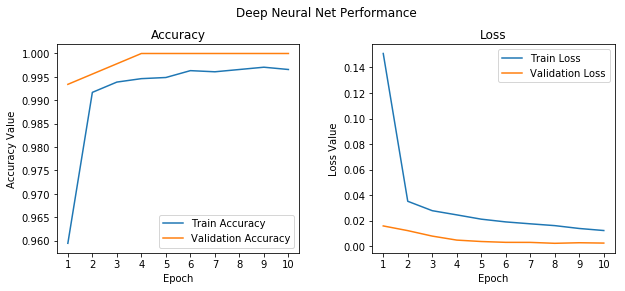

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,11))
ax1.plot(epochs, history.history['acc'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
meu.display_model_performance_metrics(true_labels=wtp_test_y, predicted_labels=wtp_dnn_predictions, 
                                      classes=['red', 'white'])

Model Performance metrics:
------------------------------
Accuracy: 0.9928
Precision: 0.9928
Recall: 0.9928
F1 Score: 0.9928

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        red       0.99      0.99      0.99       470
      white       1.00      1.00      1.00      1480

avg / total       0.99      0.99      0.99      1950


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     red white
Actual: red          463     7
        white          7  1473


### Total:
+ The F1 score is better than in logistic regression

# Model Interpretation

## View Feature importances

[11/11] features ████████████████████ Time elapsed: 0 seconds

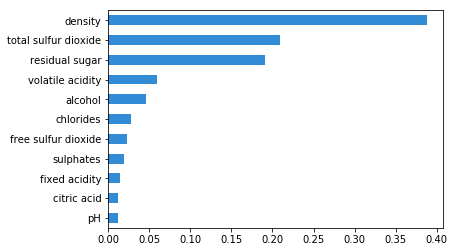

In [24]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel

wtp_interpreter = Interpretation(wtp_test_SX, feature_names=wtp_features.columns)
wtp_im_model = InMemoryModel(wtp_lr.predict_proba, examples=wtp_train_SX, target_names=wtp_lr.classes_)
plots = wtp_interpreter.feature_importance.plot_feature_importance(wtp_im_model, ascending=False)

## View model ROC curve

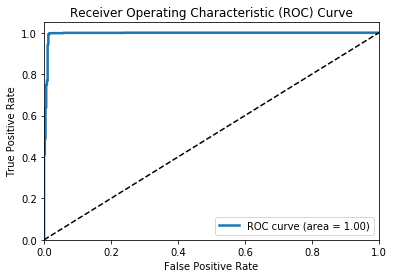

In [25]:
meu.plot_model_roc_curve(wtp_lr, wtp_test_SX, wtp_test_y)

## Visualize Model Decision Surface

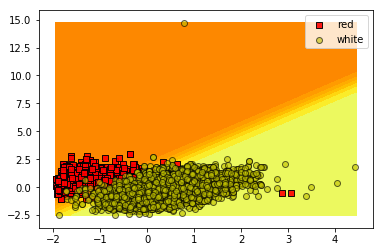

In [26]:
feature_indices = [i for i, feature in enumerate(wtp_feature_names) 
                       if feature in ['density', 'total sulfur dioxide']]
meu.plot_model_decision_surface(clf=wtp_lr, train_features=wtp_train_SX[:, feature_indices], 
                                train_labels=wtp_train_y, plot_step=0.02, cmap=plt.cm.Wistia_r,
                                markers=[',', 'o'], alphas=[0.9, 0.6], colors=['r', 'y'])

### Total:
+ our model has learned the underlying patterns quite well based on just the two most important features
+ there are very few misclassifications here and there

# Predicting Wine Quality

## Prepare Training and Testing datasets

In [10]:
wqp_features = wines.iloc[:,:-3]
wqp_class_labels = np.array(wines['quality_label'])
wqp_label_names = ['low', 'medium', 'high']
wqp_feature_names = list(wqp_features.columns)
wqp_train_X, wqp_test_X, wqp_train_y, wqp_test_y = train_test_split(wqp_features, wqp_class_labels, 
                                                                    test_size=0.3, random_state=42)

print(Counter(wqp_train_y), Counter(wqp_test_y))
print('Features:', wqp_feature_names)

Counter({'medium': 2737, 'low': 1666, 'high': 144}) Counter({'medium': 1178, 'low': 718, 'high': 54})
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


### Total:
+  we have very few wine samples of high class rating and a lot of medium quality wine samples.

## Feature Scaling

In [11]:
# Define the scaler 
wqp_ss = StandardScaler().fit(wqp_train_X)

# Scale the train set
wqp_train_SX = wqp_ss.transform(wqp_train_X)

# Scale the test set
wqp_test_SX = wqp_ss.transform(wqp_test_X)

## Train, Predict & Evaluate Model using Decision Tree 

In [12]:
from sklearn.tree import DecisionTreeClassifier

wqp_dt = DecisionTreeClassifier()
wqp_dt.fit(wqp_train_SX, wqp_train_y)

wqp_dt_predictions = wqp_dt.predict(wqp_test_SX)

meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_dt_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7251
Precision: 0.7272
Recall: 0.7251
F1 Score: 0.7261

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.68      0.67      0.68       718
     medium       0.77      0.78      0.78      1178
       high       0.25      0.30      0.27        54

avg / total       0.73      0.73      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           482    230    6
        medium        220    916   42
        high            2     36   16


### Total:
+ recall for the high quality wine samples is pretty bad since a lot of them have been misclassified into medium and low quality ratings

## View Feature Importances from Decision Tree Model

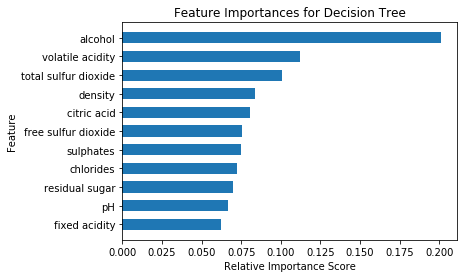

In [13]:
wqp_dt_feature_importances = wqp_dt.feature_importances_
wqp_dt_feature_names, wqp_dt_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_dt_feature_importances), 
                                                          key=lambda x: x[1]))
y_position = list(range(len(wqp_dt_feature_names)))
plt.barh(y_position, wqp_dt_feature_scores, height=0.6, align='center')
plt.yticks(y_position , wqp_dt_feature_names)
plt.xlabel('Relative Importance Score')
plt.ylabel('Feature')
t = plt.title('Feature Importances for Decision Tree')

In [15]:
print(wqp_dt_feature_names)

('fixed acidity', 'pH', 'residual sugar', 'chlorides', 'sulphates', 'free sulfur dioxide', 'citric acid', 'density', 'total sulfur dioxide', 'volatile acidity', 'alcohol')


## Visualize the Decision Tree

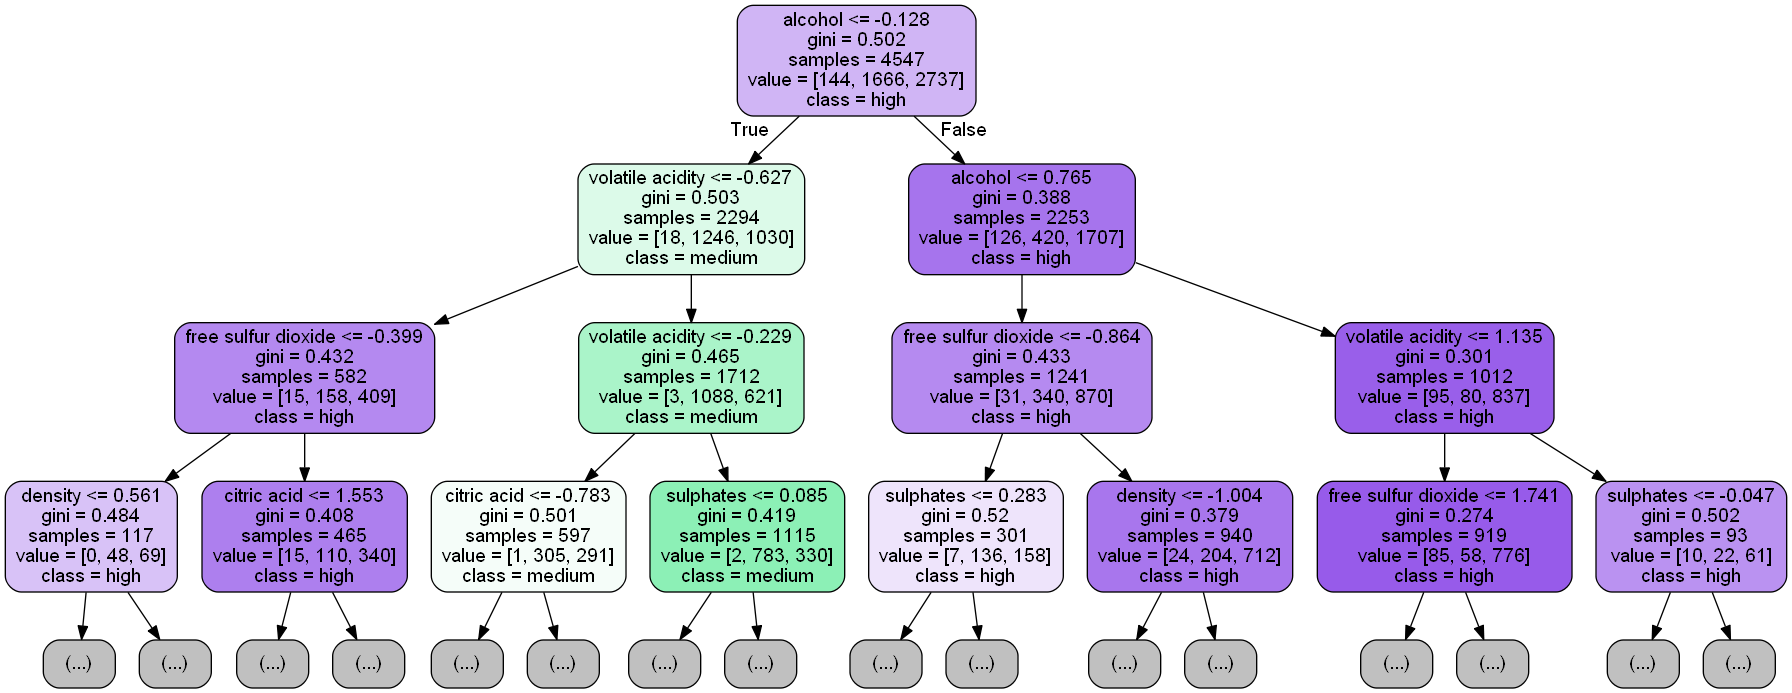

In [17]:
from graphviz import Source
from sklearn import tree
from IPython.display import Image

graph = Source(tree.export_graphviz(wqp_dt, out_file=None, class_names=wqp_label_names,
                                    filled=True, rounded=True, special_characters=False,
                                    feature_names=wqp_feature_names, max_depth=3))
png_data = graph.pipe(format='png')
with open('dtree_structure.png','wb') as f:
    f.write(png_data)

Image(png_data)

## Train, Predict & Evaluate Model using Random Forests

In [18]:
from sklearn.ensemble import RandomForestClassifier
# train the model
wqp_rf = RandomForestClassifier()
wqp_rf.fit(wqp_train_SX, wqp_train_y)
# predict and evaluate performance
wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.779
Precision: 0.7767
Recall: 0.779
F1 Score: 0.7764

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.73      0.73      0.73       718
     medium       0.81      0.83      0.82      1178
       high       0.63      0.31      0.42        54

avg / total       0.78      0.78      0.78      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           527    190    1
        medium        194    975    9
        high            4     33   17


## Hyperparameter tuning with Grid Search & Cross Validation

In [19]:
print(wqp_rf.get_params())

{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


### Get the best hyperparameter values

In [20]:
from sklearn.model_selection import GridSearchCV

param_grid = {
                'n_estimators': [100, 200, 300, 500], 
                'max_features': ['auto', None, 'log2']    
              }

wqp_clf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5,
                       scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

{'max_features': 'auto', 'n_estimators': 200}


### View grid search results

In [21]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'max_features': 'auto', 'n_estimators': 100} 0.7928 0.0119
{'max_features': 'auto', 'n_estimators': 200} 0.7955 0.0101
{'max_features': 'auto', 'n_estimators': 300} 0.7941 0.0086
{'max_features': 'auto', 'n_estimators': 500} 0.795 0.0094
{'max_features': None, 'n_estimators': 100} 0.7847 0.0144
{'max_features': None, 'n_estimators': 200} 0.781 0.0149
{'max_features': None, 'n_estimators': 300} 0.784 0.0128
{'max_features': None, 'n_estimators': 500} 0.7858 0.0107
{'max_features': 'log2', 'n_estimators': 100} 0.7928 0.0119
{'max_features': 'log2', 'n_estimators': 200} 0.7955 0.0101
{'max_features': 'log2', 'n_estimators': 300} 0.7941 0.0086
{'max_features': 'log2', 'n_estimators': 500} 0.795 0.0094


### Train, Predict & Evaluate Random Forest Model with tuned hyperparameters

In [22]:
wqp_rf = RandomForestClassifier(n_estimators=200, max_features='auto', random_state=42)
wqp_rf.fit(wqp_train_SX, wqp_train_y)

wqp_rf_predictions = wqp_rf.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_rf_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.8108
Precision: 0.8114
Recall: 0.8108
F1 Score: 0.8053

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.80      0.73      0.76       718
     medium       0.82      0.89      0.85      1178
       high       0.88      0.28      0.42        54

avg / total       0.81      0.81      0.81      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           522    196    0
        medium        132   1044    2
        high            0     39   15


## Train, Predict & Evaluate Model using Extreme Gradient Boosting

### Load and set dependencies

In [32]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-8.1.0-posix-seh-rt_v6-rev0\\mingw64\\bin'

os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb

### Train the model

In [33]:
wqp_xgb_model = xgb.XGBClassifier(seed=42)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

### Predict and Evaluate Model 

In [34]:
wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7446
Precision: 0.7443
Recall: 0.7446
F1 Score: 0.7344

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.71      0.64      0.67       718
     medium       0.76      0.84      0.80      1178
       high       0.83      0.09      0.17        54

avg / total       0.74      0.74      0.73      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           456    261    1
        medium        187    991    0
        high            1     48    5


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


### Get the best hyperparameter values

In [35]:
param_grid = {
                'n_estimators': [100, 200, 300], 
                'max_depth': [5, 10, 15],
                'learning_rate': [0.3, 0.5]
              }

wqp_clf = GridSearchCV(xgb.XGBClassifier(tree_method='exact', seed=42), param_grid, 
                       cv=5, scoring='accuracy')
wqp_clf.fit(wqp_train_SX, wqp_train_y)
print(wqp_clf.best_params_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but i

{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100}


### View grid search results

In [36]:
results = wqp_clf.cv_results_
for param, score_mean, score_sd in zip(results['params'], results['mean_test_score'], results['std_test_score']):
    print(param, round(score_mean, 4), round(score_sd, 4))

{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 100} 0.7779 0.0118
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 200} 0.7799 0.0066
{'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300} 0.7788 0.0091
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 100} 0.7871 0.0048
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 200} 0.7851 0.0048
{'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 300} 0.7803 0.0027
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 100} 0.7823 0.0107
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 200} 0.7818 0.0105
{'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 300} 0.7805 0.0112
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100} 0.7781 0.0123
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 200} 0.7735 0.0091
{'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 300} 0.7748 0.0078
{'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100} 0.7774 0.0096
{'learning_rate': 0.5, 'max_dep

### Train, Predict & Evaluate Extreme Gradient Boosted Model with tuned hyperparameters

In [37]:
wqp_xgb_model = xgb.XGBClassifier(seed=42, max_depth=10, learning_rate=0.3, n_estimators=100)
wqp_xgb_model.fit(wqp_train_SX, wqp_train_y)

wqp_xgb_predictions = wqp_xgb_model.predict(wqp_test_SX)
meu.display_model_performance_metrics(true_labels=wqp_test_y, predicted_labels=wqp_xgb_predictions, 
                                      classes=wqp_label_names)

Model Performance metrics:
------------------------------
Accuracy: 0.7887
Precision: 0.7891
Recall: 0.7887
F1 Score: 0.7841

Model Classification report:
------------------------------
             precision    recall  f1-score   support

        low       0.75      0.71      0.73       718
     medium       0.81      0.86      0.83      1178
       high       0.89      0.30      0.44        54

avg / total       0.79      0.79      0.78      1950


Prediction Confusion Matrix:
------------------------------
               Predicted:            
                      low medium high
Actual: low           511    207    0
        medium        165   1011    2
        high            3     35   16


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


# Model Interpretation

## Comparative analysis of Model Feature importances

[11/11] features ████████████████████ Time elapsed: 1 seconds

Text(0,0.5,'Feature')

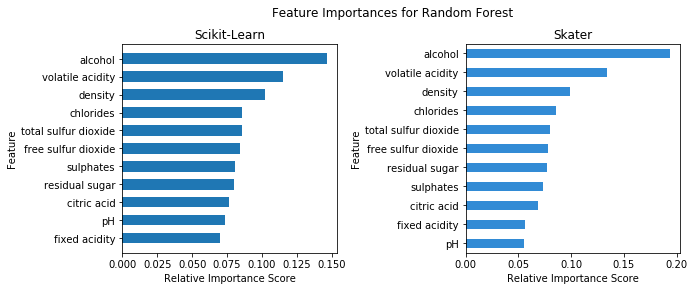

In [38]:
from skater.core.explanations import Interpretation
from skater.model import InMemoryModel
# leveraging skater for feature importances
interpreter = Interpretation(wqp_test_SX, feature_names=wqp_feature_names)
wqp_im_model = InMemoryModel(wqp_rf.predict_proba, examples=wqp_train_SX, target_names=wqp_rf.classes_)
# retrieving feature importances from the scikit-learn estimator
wqp_rf_feature_importances = wqp_rf.feature_importances_
wqp_rf_feature_names, wqp_rf_feature_scores = zip(*sorted(zip(wqp_feature_names, wqp_rf_feature_importances), 
                                                          key=lambda x: x[1]))
# plot the feature importance plots
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
t = f.suptitle('Feature Importances for Random Forest', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.6)
y_position = list(range(len(wqp_rf_feature_names)))
ax1.barh(y_position, wqp_rf_feature_scores, height=0.6, align='center', tick_label=wqp_rf_feature_names)
ax1.set_title("Scikit-Learn")
ax1.set_xlabel('Relative Importance Score')
ax1.set_ylabel('Feature')
plots = interpreter.feature_importance.plot_feature_importance(wqp_im_model, ascending=False, ax=ax2)
ax2.set_title("Skater")
ax2.set_xlabel('Relative Importance Score')
ax2.set_ylabel('Feature')

## View Model ROC Curve

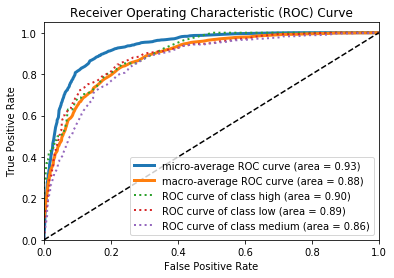

In [39]:
meu.plot_model_roc_curve(wqp_rf, wqp_test_SX, wqp_test_y)

## Visualize Model decision surface

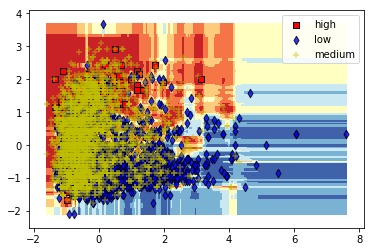

In [40]:
feature_indices = [i for i, feature in enumerate(wqp_feature_names) 
                       if feature in ['alcohol', 'volatile acidity']]
meu.plot_model_decision_surface(clf=wqp_rf, train_features=wqp_train_SX[:, feature_indices], 
                      train_labels=wqp_train_y, plot_step=0.02, cmap=plt.cm.RdYlBu,
                      markers=[',', 'd', '+'], alphas=[1.0, 0.8, 0.5], colors=['r', 'b', 'y'])

### Total:
+ the model is able to distinguish well between the classes, although there is a certain amount of overlap, especially with the wine samples of medium quality rating with high and low quality rated wine samples

## Interpreting Model Predictions

In [41]:
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

exp = LimeTabularExplainer(wqp_train_SX, feature_names=wqp_feature_names, 
                           discretize_continuous=True, 
                           class_names=wqp_rf.classes_)

In [42]:
exp.explain_instance(wqp_test_SX[10], wqp_rf.predict_proba, top_labels=1).show_in_notebook() 

In [43]:
exp.explain_instance(wqp_test_SX[747], wqp_rf.predict_proba, top_labels=1).show_in_notebook() 

## Visualizing partial dependencies

[81/81] grid cells ████████████████████ Time elapsed: 10 seconds

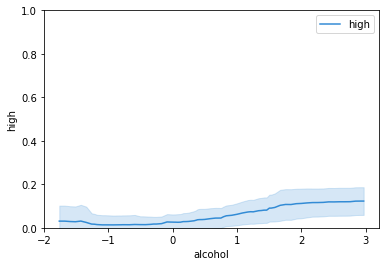

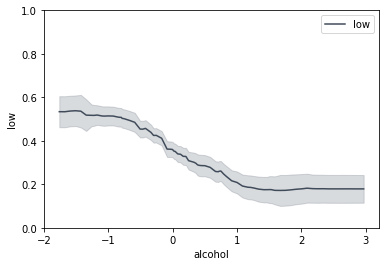

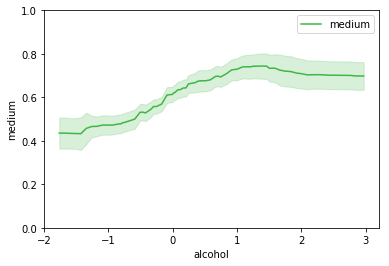

In [44]:
axes_list = interpreter.partial_dependence.plot_partial_dependence(['alcohol'], wqp_im_model, 
                                                                   grid_resolution=100, 
                                                                   with_variance=True,
                                                                   figsize = (6, 4))
axs = axes_list[0][3:]
[ax.set_ylim(0, 1) for ax in axs];

### Total:
+  with an increase in the quantity of alcohol content, the confidence\probability of the model predictor increases in predicting the wine to be either medium or high and similarly it decreases for the probability of wine to be of low quality

[4698/4698] grid cells ████████████████████ Time elapsed: 129 seconds

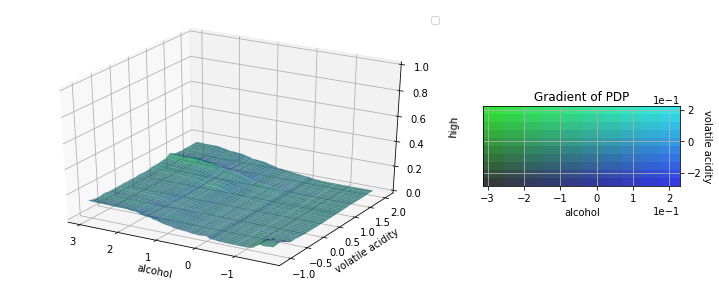

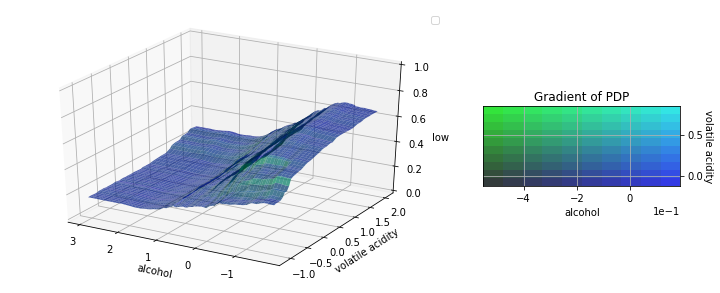

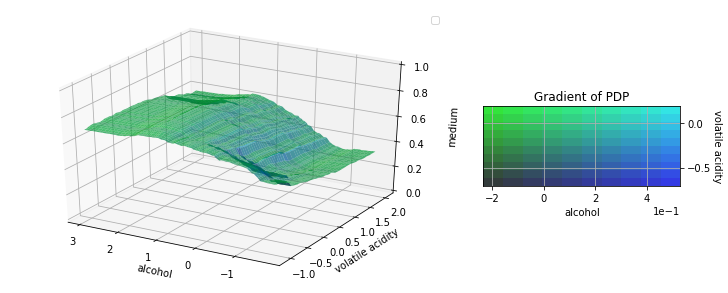

In [45]:
plots_list = interpreter.partial_dependence.plot_partial_dependence([('alcohol', 'volatile acidity')], 
                                                                    wqp_im_model, n_samples=1000, figsize=(12, 5),
                                                                    grid_resolution=100)
axs = plots_list[0][3:]
[ax.set_zlim(0, 1) for ax in axs];

### Total:
+ predicting high quality is hard because of small number of samples
+ strong dependency on low wine quality class prediction with the corresponding decrease in alcohol and the increase in volatile acidity levels
+ middle: predictions have a strong dependency with corresponding increase in alcohol and with decrease in volatile acidity levels